In [16]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import geopandas as gpd

df = pd.read_csv("../CSV/2010-2021.csv")

# create grouping of data using specified column
groupby_borough = df.groupby(['BOROUGH'])

# creates a copy of specified entry within the column group
borough = groupby_borough.get_group(('STATEN ISLAND',)).copy()
borough.drop('LOWEST SALE PRICE', axis=1, inplace=True)
borough.drop('HIGHEST SALE PRICE', axis=1, inplace=True)

# group further by home type
groupby_home = borough.groupby(['TYPE OF HOME'])
three = groupby_home.get_group(('03 THREE FAMILY HOMES',)).copy()

# set up to do regession 
hood_names_three = three['NEIGHBORHOOD'].unique()
groupby_hood = three.groupby(['NEIGHBORHOOD'])
# addresses small samples
small_sample = ["ARDEN HEIGHTS", "HUGUENOT", "GRYMES HILL", "CLOVE LAKES", 
                "OAKWOOD-BEACH", "ELTINGVILLE", "NEW DORP-HEIGHTS", "PRINCES BAY", 
                "SILVER LAKE", "TRAVIS", "GRASMERE", "PLEASANT PLAINS", "WOODROW"]

# prediction model
dic_three = {}
for h in hood_names_three:
    temp = groupby_hood.get_group((h,)).copy()
    # print(h)
    if h in small_sample:
        dic_three[h] = temp['AVERAGE SALE PRICE'].item()
    else:
        X = temp[['YEAR', 'MEDIAN SALE PRICE', 'NUMBER OF SALES']]
        y = temp['AVERAGE SALE PRICE']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        dic_three[h] = y_pred[0]

# map of neighborhood
shape = gpd.read_file("../nynta2020_24b/nynta2020.shp")

# removes all borough that isn't the working set
to_drop = shape[shape["BoroName"] != "Staten Island"].index 
shape.drop(to_drop, inplace=True) 

# removes all other columns that we don't really care for
shape = shape.drop(columns=["BoroCode", "BoroName", "CountyFIPS", "NTA2020", "NTAAbbrev", "NTAType", "CDTA2020", "Shape_Leng", "Shape_Area", "CDTAName"])

hood_names_three 

array(['ARDEN HEIGHTS', 'CONCORD', 'DONGAN HILLS', 'HUGUENOT',
       'MANOR HEIGHTS', 'MARINERS HARBOR', 'NEW BRIGHTON', 'NEW DORP',
       'ROSEBANK', 'STAPLETON', 'SUNNYSIDE', 'TOMPKINSVILLE',
       'WEST NEW BRIGHTON', 'WILLOWBROOK', 'ARROCHAR', 'GRANT CITY',
       'SOUTH BEACH', 'ANNADALE', 'GRYMES HILL', 'MIDLAND BEACH',
       'NEW DORP-BEACH', 'BULLS HEAD', 'LIVINGSTON', 'PORT RICHMOND',
       'ROSSVILLE-CHARLESTON', 'STAPLETON-CLIFTON', 'TOTTENVILLE',
       'CASTLETON CORNERS', 'CLOVE LAKES', 'DONGAN HILLS-COLONY',
       'GREAT KILLS', 'OAKWOOD-BEACH', 'ARROCHAR-SHORE ACRES',
       'NEW SPRINGVILLE', 'ELTINGVILLE', 'NEW DORP-HEIGHTS',
       'PRINCES BAY', 'SILVER LAKE', 'TRAVIS', 'WESTERLEIGH', 'GRASMERE',
       'PLEASANT PLAINS', 'RICHMONDTOWN-LIGHTHS HILL', 'WOODROW'],
      dtype=object)

In [19]:
pairs = {
    'St. George-New Brighton': 'NEW BRIGHTON',
    'Tompkinsville-Stapleton-Clifton-Fox Hills': 'STAPLETON',
    'Rosebank-Shore Acres-Park Hill': 'ROSEBANK',
    'West New Brighton-Silver Lake-Grymes Hill': 'WEST NEW BRIGHTON',
    'Westerleigh-Castleton Corners': 'CASTLETON CORNERS',
    'Port Richmond': 'PORT RICHMOND',
    "Mariner's Harbor-Arlington-Graniteville": 'MARINERS HARBOR',
    'Snug Harbor': None,
    'Grasmere-Arrochar-South Beach-Dongan Hills': 'ARROCHAR-SHORE ACRES',
    'New Dorp-Midland Beach': 'MIDLAND BEACH',
    'Todt Hill-Emerson Hill-Lighthouse Hill-Manor Heights': 'MANOR HEIGHTS',
    'New Springville-Willowbrook-Bulls Head-Travis': 'TOTTENVILLE',
    'Freshkills Park (North)': None,
    'Oakwood-Richmondtown': None,
    'Great Kills-Eltingville': 'GREAT KILLS',
    'Arden Heights-Rossville': 'ARDEN HEIGHTS',
    "Annadale-Huguenot-Prince's Bay-Woodrow": 'ANNADALE',
    'Tottenville-Charleston': 'TOTTENVILLE',
    'Freshkills Park (South)': None,
    'Fort Wadsworth': None,
    'Hoffman & Swinburne Islands': None,
    'Miller Field': None,
    'Great Kills Park': 'GREAT KILLS'
}


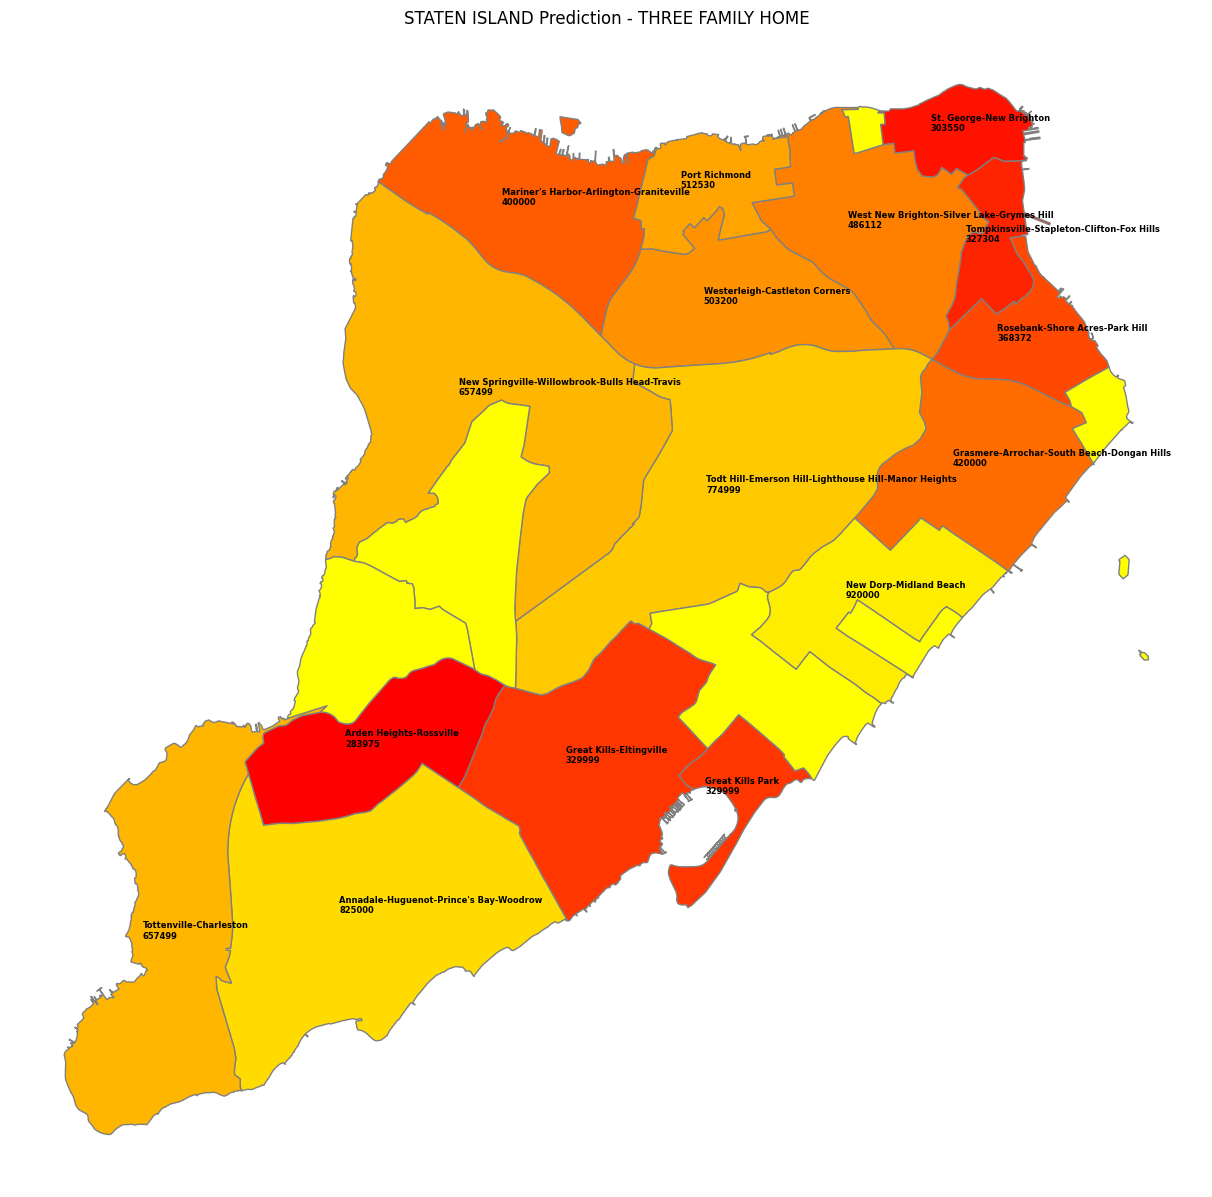

In [20]:
import matplotlib.pyplot as plt

shape['sales'] = "-"

# adding sales data to overall df
for i, row in shape.iterrows():
    holder = pairs[row['NTAName']]
    if holder:
        if isinstance(holder, list):
            sum = 0
            for e in holder:
                sum += dic_three[e]
            shape.at[i, 'sales'] = int(sum/len(holder))
        else:
            shape.at[i, 'sales'] = int(dic_three[holder])

# sets map settings
shape_map = shape.plot(column='sales', k=8, cmap='autumn', figsize=(30,15), linewidth=1, edgecolor='0.5')
# adds labels to map
for i, row in shape.iterrows():
    x = row['geometry'].centroid.x
    y = row['geometry'].centroid.y
    if row['sales'] != "-" :
        label = row['NTAName'] + "\n" + str(row['sales'])
        shape_map.annotate(label, xy=(x, y), xytext=(-20, 0), color="black", textcoords="offset points", fontsize=6, weight="bold")
# draws the map
shape_map.set(title="STATEN ISLAND Prediction - THREE FAMILY HOME")
shape_map.set_axis_off()